In [3]:
import torch
import numpy as np
import os
import cma
from eval import play
from gan.config import SmallModelConfig
from gan.models.small_models import Generator
from play_rl.zelda_astar import play_astar
from gan.utils import tensor_to_level_str,check_playable
from gan.level_visualizer import GVGAILevelVisualizer
from play_rl.env import Env
from play_rl.wrappers import GridGame
from play_rl.policy import Policy
from PIL import Image

In [32]:
config = SmallModelConfig()
config.set_env()
config.cuda = False
if config.cuda:
    device = torch.device(
        "cuda" if torch.cuda.is_available else "cpu")
    print("device : cuda")
else:
    device = torch.device("cpu")
    print("device : cpu")
generator = Generator(
    out_dim=config.input_shape[0],
    shapes=config.model_shapes,
    z_shape=(config.latent_size,),
    filters=config.generator_filters,
    use_linear4z2features_g=False
).to(device)
env_def = Env(config.env_name,config.env_version)
level_visualizer = GVGAILevelVisualizer(env=env_def)

# model_path = os.path.join(
#     "/root/mnt/GVGAI-GAN/gan/checkpoints/_ours-152", "models_3800.tar")
# model_path = os.path.join(
#     "/root/mnt/GVGAI-GAN/gan/checkpoints/_boot_baseline-161", "models_3500.tar")
# model_path = os.path.join(
#     '/root/mnt/GVGAI-GAN/gan/checkpoints/_only5-121','models_1240.tar'
# )

# model_path = "/root/mnt/pcg/GVGAI-GAN/gan/checkpoints/_only5/models_10000.tar"
# model_path = "/root/mnt/pcg/GVGAI-GAN/gan/checkpoints/_baseline-boot-371/latest.tar"
# model_path = "/root/mnt/pcg/GVGAI-GAN/gan/checkpoints/_ours1-366/models_3000.tar"
model_path = "/root/mnt/pcg/GVGAI-GAN/gan/checkpoints/_ours2-369/models_1660.tar"

load_model = torch.load(model_path)
generator.load_state_dict(load_model["generator"])
x = torch.randn(config.latent_size).to(device)


device : cpu


(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=279730, Fri Oct  7 13:24:11 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 1.000000000000000e+02 1.0e+00 4.71e-01  5e-01  5e-01 0:00.1
    2     28 8.200000000000000e+01 1.1e+00 4.51e-01  4e-01  5e-01 0:00.2
    3     42 1.000000000000000e+02 1.1e+00 4.32e-01  4e-01  4e-01 0:00.3
    4     56 1.000000000000000e+02 1.1e+00 4.21e-01  4e-01  4e-01 0:00.4
    5     70 1.000000000000000e+02 1.1e+00 4.24e-01  4e-01  4e-01 0:00.5
    6     84 1.000000000000000e+02 1.1e+00 4.23e-01  4e-01  4e-01 0:00.6
    7     98 1.000000000000000e+02 1.2e+00 4.30e-01  4e-01  4e-01 0:00.7
   10    140 1.000000000000000e+02 1.2e+00 4.24e-01  4e-01  4e-01 0:00.9
   11    154 1.000000000000000e+02 1.3e+00 4.24e-01  4e-01  4e-01 0:01.0
   12    168 1.000000000000000e+02 1.3e+00 4.33e-01  4e-01  4e-01 0:01.1
   13    182 1.000000000000000e+02 1.3e+00 4.45e-01  4e-01  5e-01 0:01.2
  100   1400 6.300000000000000e+0

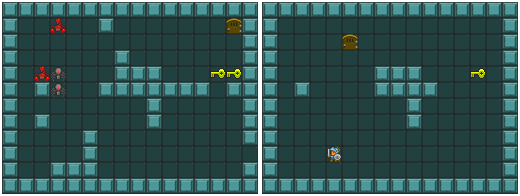

In [43]:
def f1(level_str):
    wall = 0
    enemy = 0
    for i, s in enumerate(level_str):
        for j, c in enumerate(s):
            if c == 'w':
                wall += 1
            if c in ['1', '2', '3']:
                enemy += 1
    return - wall - 5* enemy


def f2(level_str):
    wall = 0
    enemy = 0
    for i, s in enumerate(level_str):
        for j, c in enumerate(s):
            if c == 'w':
                wall += 1
            if c in ['1', '2', '3']:
                enemy += 1
    return wall + enemy

# env = GridGame(config.env_name, 200, env_def.state_shape)
# actor = Policy(env.observation_space.shape, env.action_space,base_kwargs={"recurrent": True})
# actor.load_state_dict(torch.load('/root/mnt/GVGAI-GAN/play_rl/checkpoints/ppo/zelda_20220825102126.pt'))

def fitnessf1(x: torch.Tensor):
    x = np.array(x)
    latent = torch.FloatTensor(x).view(1, -1, 1, 1)
    level = generator(latent)
    level_str = tensor_to_level_str('zelda', level)
    playable = check_playable(level_str[0],config.env_fullname)
    if not playable:
        return 100
    # reward,step,_ = play(level_str[0],env=env,actor=actor)
    # reward, step, _ = play_astar(level_str[0], env=env)

    # return -(reward*100+step)
    ev = f1(level_str)
    return ev


def fitnessf2(x: torch.Tensor):
    x = np.array(x)
    latent = torch.FloatTensor(x).view(1, -1, 1, 1)
    level = generator(latent)
    level_str = tensor_to_level_str('zelda', level)
    playable = check_playable(level_str[0], config.env_fullname)
    if not playable:
        return 100
    # reward,step,_ = play(level_str[0],env=env,actor=actor)
    # reward, step, _ = play_astar(level_str[0], env=env)

    # return -(reward*100+step)
    ev = f2(level_str)
    return ev

def show(x):
    p_level = torch.nn.Softmax2d()(generator(x))
    level_strs = tensor_to_level_str(
        config.env_name, p_level)
    p_level_img = np.array(level_visualizer.draw_level(level_strs[0]))
    image = Image.fromarray(p_level_img)
    image.show()


def show2(x,x2):
    p_level = torch.nn.Softmax2d()(generator(x))
    level_strs = tensor_to_level_str(
        config.env_name, p_level)
    p_level_img1 = np.array(level_visualizer.draw_level(level_strs[0]))
    p_level = torch.nn.Softmax2d()(generator(x2))
    level_strs = tensor_to_level_str(
        config.env_name, p_level)
    p_level_img2 = np.array(level_visualizer.draw_level(level_strs[0]))
    concated = np.concatenate([p_level_img1,p_level_img2],axis=1)
    image = Image.fromarray(concated)
    image.show()

    
x = torch.randn(config.latent_size).to(device)
es = cma.CMAEvolutionStrategy(x.tolist(), 0.5)
# es.optimize(fitness,iterations=30,min_iterations=30)
es.optimize(fitnessf2,min_iterations=150,max_iterations=150)
best = np.array(es.best.get()[0])
print("INIT: ", np.array(x.tolist()))
print("BEST: ", best)
print("Fitness: ", fitnessf1(best))
# show(x)
# show(torch.FloatTensor(best))
show2(x,torch.FloatTensor(best))

# sum = 0
# N = 10
# for i in range(N):
#     x = torch.randn(config.latent_size).to(device)
#     es = cma.CMAEvolutionStrategy(x.tolist(), 0.5)
#     es.optimize(fitness)
#     best = np.array(es.best.get()[0])
#     sum += fitness(best)

# print("mean:",best/N)


(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=230246, Fri Oct  7 12:49:38 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -8.100000000000000e+01 1.0e+00 4.73e-01  5e-01  5e-01 0:00.1
    2     28 -8.200000000000000e+01 1.1e+00 4.67e-01  5e-01  5e-01 0:00.3
    3     42 -8.100000000000000e+01 1.1e+00 4.60e-01  5e-01  5e-01 0:00.3
   37    518 -9.500000000000000e+01 2.0e+00 7.61e-01  7e-01  9e-01 0:03.4
   52    728 -9.500000000000000e+01 2.0e+00 6.06e-01  6e-01  7e-01 0:04.6
   58    812 -9.500000000000000e+01 2.0e+00 5.62e-01  5e-01  6e-01 0:05.1
   59    826 -9.500000000000000e+01 2.0e+00 5.49e-01  5e-01  6e-01 0:05.2
   60    840 -9.500000000000000e+01 2.0e+00 5.45e-01  5e-01  6e-01 0:05.2
   68    952 -9.500000000000000e+01 2.1e+00 5.33e-01  5e-01  6e-01 0:06.0
   71    994 -9.500000000000000e+01 2.1e+00 4.92e-01  4e-01  5e-01 0:06.2
   72   1008 -9.500000000000000e+01 2.1e+00 4.89e-01  4e-01  5e-01 0:06.3
   75   1050 -9.500000

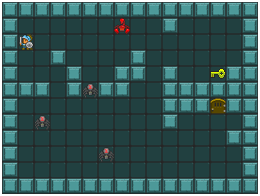

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=250118, Fri Oct  7 12:49:51 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -8.800000000000000e+01 1.0e+00 4.70e-01  5e-01  5e-01 0:00.1
    2     28 -8.900000000000000e+01 1.1e+00 4.54e-01  4e-01  5e-01 0:00.2
    3     42 -9.200000000000000e+01 1.1e+00 4.50e-01  4e-01  5e-01 0:00.3
   40    560 -1.040000000000000e+02 2.0e+00 8.79e-01  8e-01  1e+00 0:03.4
   87   1218 -1.070000000000000e+02 2.9e+00 8.02e-01  7e-01  1e+00 0:07.4
   91   1274 -1.070000000000000e+02 3.0e+00 7.18e-01  7e-01  9e-01 0:07.7
  100   1400 -1.070000000000000e+02 3.1e+00 6.59e-01  6e-01  9e-01 0:08.5
  120   1680 -1.070000000000000e+02 3.4e+00 7.80e-01  7e-01  1e+00 0:10.1
  127   1778 -1.070000000000000e+02 3.5e+00 6.96e-01  6e-01  9e-01 0:10.7
  128   1792 -1.070000000000000e+02 3.5e+00 6.93e-01  6e-01  9e-01 0:10.8
  129   1806 -1.070000000000000e+02 3.5e+00 6.93e-01  6e-01  9e-01 0:10.9
  130   1820 -1.070000

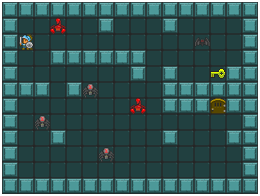

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=212074, Fri Oct  7 12:50:05 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -9.100000000000000e+01 1.0e+00 4.78e-01  5e-01  5e-01 0:00.1
    2     28 -8.900000000000000e+01 1.1e+00 4.70e-01  5e-01  5e-01 0:00.2
    3     42 -9.000000000000000e+01 1.1e+00 4.74e-01  5e-01  5e-01 0:00.3
   39    546 -9.300000000000000e+01 1.6e+00 5.49e-01  5e-01  6e-01 0:03.3
   66    924 -9.300000000000000e+01 2.0e+00 4.29e-01  4e-01  5e-01 0:05.6
   67    938 -9.300000000000000e+01 2.0e+00 4.22e-01  4e-01  5e-01 0:05.6
   68    952 -9.300000000000000e+01 2.0e+00 4.19e-01  4e-01  4e-01 0:05.7
   71    994 -9.300000000000000e+01 2.0e+00 4.19e-01  4e-01  4e-01 0:06.0
   72   1008 -9.300000000000000e+01 2.0e+00 4.21e-01  4e-01  4e-01 0:06.1
   73   1022 -9.300000000000000e+01 2.0e+00 4.21e-01  4e-01  4e-01 0:06.1
   74   1036 -9.300000000000000e+01 2.0e+00 4.30e-01  4e-01  5e-01 0:06.2
   75   1050 -9.300000

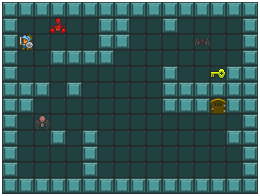

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=214976, Fri Oct  7 12:50:18 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -9.000000000000000e+01 1.0e+00 4.70e-01  5e-01  5e-01 0:00.1
    2     28 -9.000000000000000e+01 1.1e+00 4.56e-01  5e-01  5e-01 0:00.2
    3     42 -9.700000000000000e+01 1.1e+00 4.50e-01  4e-01  5e-01 0:00.3
   36    504 -1.000000000000000e+02 1.8e+00 5.34e-01  5e-01  6e-01 0:03.2
   45    630 -1.000000000000000e+02 1.9e+00 4.53e-01  4e-01  5e-01 0:04.0
   46    644 -1.000000000000000e+02 1.9e+00 4.56e-01  4e-01  5e-01 0:04.1
   47    658 -1.000000000000000e+02 1.9e+00 4.61e-01  4e-01  5e-01 0:04.2
   51    714 -1.000000000000000e+02 1.9e+00 4.29e-01  4e-01  5e-01 0:04.6
   54    756 -1.000000000000000e+02 1.9e+00 3.96e-01  4e-01  4e-01 0:04.8
   55    770 -1.000000000000000e+02 1.9e+00 3.83e-01  4e-01  4e-01 0:04.9
   56    784 -1.000000000000000e+02 1.9e+00 3.70e-01  3e-01  4e-01 0:05.0
   57    798 -1.000000

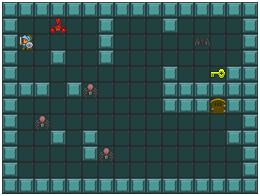

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=242146, Fri Oct  7 12:50:32 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -8.800000000000000e+01 1.0e+00 4.71e-01  5e-01  5e-01 0:00.1
    2     28 -8.800000000000000e+01 1.1e+00 4.48e-01  4e-01  5e-01 0:00.2
    3     42 -9.000000000000000e+01 1.1e+00 4.28e-01  4e-01  4e-01 0:00.3
   35    490 -9.700000000000000e+01 1.8e+00 5.01e-01  5e-01  5e-01 0:03.3
   83   1162 -1.000000000000000e+02 2.5e+00 3.31e-01  3e-01  4e-01 0:07.4
   93   1302 -1.000000000000000e+02 2.6e+00 2.63e-01  2e-01  3e-01 0:08.3
   94   1316 -1.000000000000000e+02 2.6e+00 2.58e-01  2e-01  3e-01 0:08.3
   95   1330 -1.000000000000000e+02 2.6e+00 2.53e-01  2e-01  3e-01 0:08.4
   96   1344 -1.000000000000000e+02 2.6e+00 2.45e-01  2e-01  3e-01 0:08.5
   97   1358 -1.000000000000000e+02 2.6e+00 2.38e-01  2e-01  3e-01 0:08.6
   98   1372 -1.000000000000000e+02 2.6e+00 2.36e-01  2e-01  3e-01 0:08.7
   99   1386 -1.000000

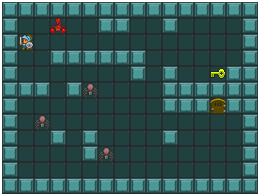

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=188240, Fri Oct  7 12:50:46 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -8.600000000000000e+01 1.0e+00 4.78e-01  5e-01  5e-01 0:00.1
    2     28 -8.400000000000000e+01 1.1e+00 4.67e-01  5e-01  5e-01 0:00.2
    3     42 -8.500000000000000e+01 1.1e+00 4.56e-01  5e-01  5e-01 0:00.3
   35    490 -9.800000000000000e+01 1.7e+00 5.58e-01  5e-01  6e-01 0:03.4
   38    532 -9.800000000000000e+01 1.7e+00 5.45e-01  5e-01  6e-01 0:03.6
   39    546 -9.800000000000000e+01 1.7e+00 5.29e-01  5e-01  6e-01 0:03.7
   50    700 -9.800000000000000e+01 1.8e+00 4.53e-01  4e-01  5e-01 0:04.7
   51    714 -9.800000000000000e+01 1.8e+00 4.49e-01  4e-01  5e-01 0:04.8
   52    728 -9.800000000000000e+01 1.8e+00 4.42e-01  4e-01  5e-01 0:04.9
   53    742 -9.800000000000000e+01 1.8e+00 4.37e-01  4e-01  5e-01 0:05.0
   54    756 -9.800000000000000e+01 1.8e+00 4.46e-01  4e-01  5e-01 0:05.0
   55    770 -9.800000

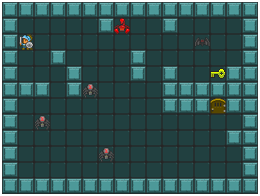

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=217036, Fri Oct  7 12:51:00 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -8.800000000000000e+01 1.0e+00 4.84e-01  5e-01  5e-01 0:00.1
    2     28 -8.500000000000000e+01 1.1e+00 4.73e-01  5e-01  5e-01 0:00.2
    3     42 -9.000000000000000e+01 1.1e+00 4.78e-01  5e-01  5e-01 0:00.3
   35    490 -9.500000000000000e+01 1.8e+00 8.14e-01  8e-01  9e-01 0:03.3
   44    616 -9.500000000000000e+01 2.0e+00 8.79e-01  8e-01  1e+00 0:04.1
   45    630 -9.500000000000000e+01 2.0e+00 8.79e-01  8e-01  1e+00 0:04.2
   58    812 -9.500000000000000e+01 2.1e+00 8.00e-01  8e-01  9e-01 0:05.3
   59    826 -9.500000000000000e+01 2.1e+00 7.83e-01  7e-01  9e-01 0:05.4
   60    840 -9.500000000000000e+01 2.1e+00 7.65e-01  7e-01  8e-01 0:05.5
   61    854 -9.500000000000000e+01 2.1e+00 7.50e-01  7e-01  8e-01 0:05.6
   62    868 -9.500000000000000e+01 2.1e+00 7.59e-01  7e-01  8e-01 0:05.6
   63    882 -9.500000

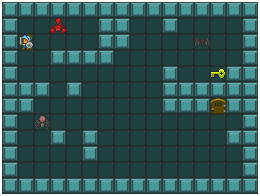

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=171490, Fri Oct  7 12:51:14 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -9.800000000000000e+01 1.0e+00 4.61e-01  5e-01  5e-01 0:00.1
    2     28 -1.000000000000000e+02 1.1e+00 4.48e-01  4e-01  5e-01 0:00.2
    3     42 -9.700000000000000e+01 1.1e+00 4.38e-01  4e-01  4e-01 0:00.3
   35    490 -1.050000000000000e+02 2.0e+00 7.53e-01  7e-01  8e-01 0:03.4
   46    644 -1.050000000000000e+02 2.1e+00 5.38e-01  5e-01  6e-01 0:04.3
   49    686 -1.050000000000000e+02 2.1e+00 5.14e-01  5e-01  6e-01 0:04.5
   50    700 -1.050000000000000e+02 2.1e+00 5.02e-01  5e-01  6e-01 0:04.6
   51    714 -1.050000000000000e+02 2.1e+00 4.92e-01  5e-01  6e-01 0:04.6
   52    728 -1.050000000000000e+02 2.1e+00 4.87e-01  5e-01  6e-01 0:04.7
   53    742 -1.050000000000000e+02 2.1e+00 4.82e-01  5e-01  5e-01 0:04.8
   54    756 -1.050000000000000e+02 2.1e+00 4.73e-01  4e-01  5e-01 0:04.9
   55    770 -1.050000

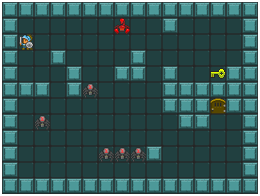

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=191932, Fri Oct  7 12:51:27 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -9.600000000000000e+01 1.0e+00 4.69e-01  5e-01  5e-01 0:00.1
    2     28 -1.010000000000000e+02 1.1e+00 4.48e-01  4e-01  5e-01 0:00.2
    3     42 -1.010000000000000e+02 1.1e+00 4.35e-01  4e-01  4e-01 0:00.3
   39    546 -1.100000000000000e+02 1.9e+00 7.28e-01  7e-01  8e-01 0:03.4
   67    938 -1.110000000000000e+02 2.0e+00 4.84e-01  5e-01  5e-01 0:05.7
   68    952 -1.110000000000000e+02 2.1e+00 4.75e-01  4e-01  5e-01 0:05.8
   69    966 -1.110000000000000e+02 2.1e+00 4.68e-01  4e-01  5e-01 0:05.9
   70    980 -1.110000000000000e+02 2.1e+00 4.66e-01  4e-01  5e-01 0:06.0
   71    994 -1.110000000000000e+02 2.1e+00 4.61e-01  4e-01  5e-01 0:06.0
   72   1008 -1.110000000000000e+02 2.1e+00 4.65e-01  4e-01  5e-01 0:06.1
   79   1106 -1.110000000000000e+02 2.2e+00 5.02e-01  5e-01  5e-01 0:06.7
   80   1120 -1.110000

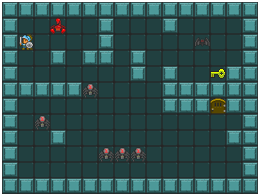

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=340081, Fri Oct  7 12:51:39 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -8.300000000000000e+01 1.0e+00 4.64e-01  5e-01  5e-01 0:00.1
    2     28 -8.700000000000000e+01 1.0e+00 4.49e-01  4e-01  5e-01 0:00.2
    3     42 -8.800000000000000e+01 1.1e+00 4.46e-01  4e-01  4e-01 0:00.3
   36    504 -9.800000000000000e+01 1.7e+00 6.60e-01  6e-01  7e-01 0:03.3
   44    616 -9.800000000000000e+01 1.7e+00 5.81e-01  6e-01  6e-01 0:04.0
   61    854 -9.900000000000000e+01 1.9e+00 4.49e-01  4e-01  5e-01 0:05.3
   62    868 -9.900000000000000e+01 1.9e+00 4.53e-01  4e-01  5e-01 0:05.4
   63    882 -9.900000000000000e+01 1.9e+00 4.52e-01  4e-01  5e-01 0:05.5
   64    896 -9.900000000000000e+01 2.0e+00 4.51e-01  4e-01  5e-01 0:05.6
   65    910 -9.900000000000000e+01 2.0e+00 4.52e-01  4e-01  5e-01 0:05.6
   76   1064 -9.900000000000000e+01 2.0e+00 4.15e-01  4e-01  5e-01 0:06.5
   84   1176 -9.900000

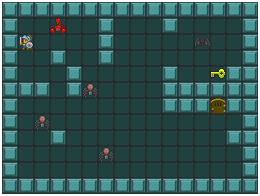

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=158899, Fri Oct  7 12:51:53 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -8.600000000000000e+01 1.0e+00 4.66e-01  5e-01  5e-01 0:00.1
    2     28 -8.900000000000000e+01 1.1e+00 4.45e-01  4e-01  4e-01 0:00.2
    3     42 -8.900000000000000e+01 1.1e+00 4.35e-01  4e-01  4e-01 0:00.3
   39    546 -9.500000000000000e+01 1.8e+00 5.99e-01  6e-01  6e-01 0:03.3
   55    770 -9.500000000000000e+01 1.9e+00 4.23e-01  4e-01  4e-01 0:04.7
   56    784 -9.500000000000000e+01 1.8e+00 4.16e-01  4e-01  4e-01 0:04.7
   57    798 -9.500000000000000e+01 1.8e+00 4.10e-01  4e-01  4e-01 0:04.8
   58    812 -9.500000000000000e+01 1.8e+00 4.08e-01  4e-01  4e-01 0:04.9
   59    826 -9.500000000000000e+01 1.8e+00 4.07e-01  4e-01  4e-01 0:05.0
   60    840 -9.500000000000000e+01 1.8e+00 4.05e-01  4e-01  4e-01 0:05.1
   61    854 -9.500000000000000e+01 1.8e+00 4.03e-01  4e-01  4e-01 0:05.2
   62    868 -9.500000

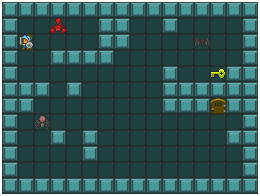

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=223516, Fri Oct  7 12:52:06 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -9.500000000000000e+01 1.0e+00 4.77e-01  5e-01  5e-01 0:00.1
    2     28 -9.600000000000000e+01 1.1e+00 4.60e-01  5e-01  5e-01 0:00.2
    3     42 -9.600000000000000e+01 1.1e+00 4.48e-01  4e-01  5e-01 0:00.3
   38    532 -9.800000000000000e+01 1.7e+00 4.59e-01  4e-01  5e-01 0:03.4
   64    896 -9.800000000000000e+01 2.0e+00 5.15e-01  5e-01  6e-01 0:05.5
   73   1022 -9.800000000000000e+01 2.1e+00 4.81e-01  4e-01  6e-01 0:06.4
   76   1064 -9.800000000000000e+01 2.1e+00 4.68e-01  4e-01  5e-01 0:06.6
   77   1078 -9.800000000000000e+01 2.1e+00 4.66e-01  4e-01  5e-01 0:06.7
   78   1092 -9.800000000000000e+01 2.1e+00 4.54e-01  4e-01  5e-01 0:06.8
   81   1134 -9.800000000000000e+01 2.1e+00 4.48e-01  4e-01  5e-01 0:07.0
   82   1148 -9.800000000000000e+01 2.1e+00 4.43e-01  4e-01  5e-01 0:07.1
   83   1162 -9.800000

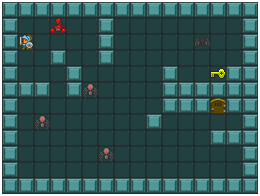

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=234393, Fri Oct  7 12:52:19 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -9.600000000000000e+01 1.0e+00 4.76e-01  5e-01  5e-01 0:00.1
    2     28 -9.800000000000000e+01 1.1e+00 4.56e-01  5e-01  5e-01 0:00.3
    3     42 -1.010000000000000e+02 1.1e+00 4.43e-01  4e-01  4e-01 0:00.4
   39    546 -1.080000000000000e+02 1.7e+00 5.17e-01  5e-01  5e-01 0:03.4
   68    952 -1.090000000000000e+02 2.0e+00 5.02e-01  5e-01  5e-01 0:05.8
   69    966 -1.090000000000000e+02 2.0e+00 4.89e-01  5e-01  5e-01 0:05.8
   70    980 -1.090000000000000e+02 2.0e+00 4.80e-01  4e-01  5e-01 0:05.9
   71    994 -1.090000000000000e+02 2.0e+00 4.83e-01  4e-01  5e-01 0:06.0
   72   1008 -1.090000000000000e+02 2.1e+00 4.88e-01  4e-01  5e-01 0:06.1
   89   1246 -1.090000000000000e+02 2.2e+00 4.91e-01  5e-01  5e-01 0:07.4
   98   1372 -1.090000000000000e+02 2.3e+00 4.72e-01  4e-01  5e-01 0:08.2
  100   1400 -1.090000

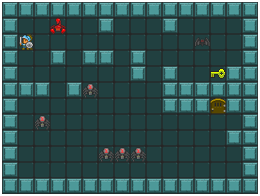

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=295660, Fri Oct  7 12:52:32 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -8.600000000000000e+01 1.0e+00 4.71e-01  5e-01  5e-01 0:00.1
    2     28 -8.700000000000000e+01 1.1e+00 4.42e-01  4e-01  4e-01 0:00.2
    3     42 -8.700000000000000e+01 1.1e+00 4.22e-01  4e-01  4e-01 0:00.3
   37    518 -9.600000000000000e+01 1.7e+00 7.14e-01  7e-01  8e-01 0:03.4
   84   1176 -9.800000000000000e+01 2.4e+00 9.09e-01  8e-01  1e+00 0:07.4
  100   1400 -9.800000000000000e+01 2.7e+00 8.72e-01  8e-01  1e+00 0:08.8
  112   1568 -9.800000000000000e+01 2.8e+00 7.40e-01  7e-01  1e+00 0:09.8
  117   1638 -9.800000000000000e+01 2.9e+00 6.19e-01  5e-01  8e-01 0:10.2
  118   1652 -9.800000000000000e+01 2.9e+00 6.17e-01  5e-01  8e-01 0:10.3
  123   1722 -9.800000000000000e+01 2.9e+00 6.21e-01  5e-01  8e-01 0:10.8
  124   1736 -9.800000000000000e+01 2.9e+00 6.16e-01  5e-01  8e-01 0:10.9
  125   1750 -9.800000

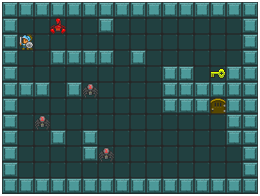

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=202917, Fri Oct  7 12:52:46 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -9.000000000000000e+01 1.0e+00 4.67e-01  5e-01  5e-01 0:00.1
    2     28 -9.000000000000000e+01 1.1e+00 4.50e-01  4e-01  5e-01 0:00.2
    3     42 -9.300000000000000e+01 1.1e+00 4.42e-01  4e-01  4e-01 0:00.3
   39    546 -1.060000000000000e+02 1.8e+00 5.87e-01  6e-01  6e-01 0:03.4
   84   1176 -1.070000000000000e+02 2.2e+00 3.71e-01  3e-01  4e-01 0:07.4
  100   1400 -1.070000000000000e+02 2.3e+00 2.84e-01  3e-01  3e-01 0:08.8
  112   1568 -1.070000000000000e+02 2.4e+00 2.30e-01  2e-01  3e-01 0:09.8
  113   1582 -1.070000000000000e+02 2.4e+00 2.30e-01  2e-01  3e-01 0:09.9
  114   1596 -1.070000000000000e+02 2.4e+00 2.31e-01  2e-01  3e-01 0:10.0
  115   1610 -1.070000000000000e+02 2.4e+00 2.26e-01  2e-01  3e-01 0:10.1
  116   1624 -1.070000000000000e+02 2.4e+00 2.22e-01  2e-01  2e-01 0:10.2
  117   1638 -1.070000

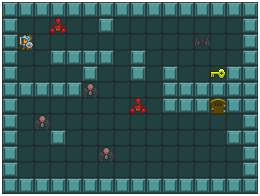

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=279004, Fri Oct  7 12:52:59 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -8.600000000000000e+01 1.0e+00 4.75e-01  5e-01  5e-01 0:00.1
    2     28 -8.700000000000000e+01 1.1e+00 4.59e-01  5e-01  5e-01 0:00.2
    3     42 -8.700000000000000e+01 1.1e+00 4.53e-01  4e-01  5e-01 0:00.3
   39    546 -9.400000000000000e+01 1.8e+00 3.89e-01  4e-01  4e-01 0:03.4
   43    602 -9.400000000000000e+01 1.8e+00 4.01e-01  4e-01  4e-01 0:03.7
   47    658 -9.400000000000000e+01 1.8e+00 4.28e-01  4e-01  5e-01 0:04.1
   48    672 -9.400000000000000e+01 1.9e+00 4.28e-01  4e-01  5e-01 0:04.1
   51    714 -9.400000000000000e+01 1.9e+00 4.22e-01  4e-01  5e-01 0:04.4
   52    728 -9.400000000000000e+01 1.9e+00 4.19e-01  4e-01  5e-01 0:04.5
   53    742 -9.400000000000000e+01 1.9e+00 4.15e-01  4e-01  5e-01 0:04.6
   54    756 -9.400000000000000e+01 1.9e+00 4.07e-01  4e-01  5e-01 0:04.6
   61    854 -9.400000

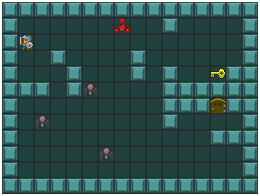

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=246209, Fri Oct  7 12:53:13 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -8.000000000000000e+01 1.0e+00 4.70e-01  5e-01  5e-01 0:00.1
    2     28 -8.000000000000000e+01 1.1e+00 4.55e-01  5e-01  5e-01 0:00.2
    3     42 -8.200000000000000e+01 1.1e+00 4.54e-01  4e-01  5e-01 0:00.3
   36    504 -9.500000000000000e+01 2.0e+00 9.82e-01  9e-01  1e+00 0:03.3
   84   1176 -9.500000000000000e+01 2.6e+00 7.39e-01  7e-01  9e-01 0:07.3
   85   1190 -9.500000000000000e+01 2.6e+00 7.51e-01  7e-01  9e-01 0:07.4
  100   1400 -9.500000000000000e+01 2.8e+00 7.26e-01  7e-01  9e-01 0:08.8
  106   1484 -9.500000000000000e+01 2.8e+00 7.74e-01  7e-01  9e-01 0:09.2
  112   1568 -9.500000000000000e+01 2.8e+00 7.37e-01  7e-01  9e-01 0:09.7
  113   1582 -9.500000000000000e+01 2.8e+00 7.38e-01  7e-01  9e-01 0:09.8
  114   1596 -9.500000000000000e+01 2.8e+00 7.51e-01  7e-01  9e-01 0:09.9
  115   1610 -9.500000

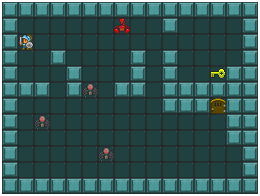

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=282827, Fri Oct  7 12:53:26 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -9.300000000000000e+01 1.0e+00 4.70e-01  5e-01  5e-01 0:00.1
    2     28 -9.400000000000000e+01 1.1e+00 4.58e-01  5e-01  5e-01 0:00.2
    3     42 -9.600000000000000e+01 1.1e+00 4.55e-01  5e-01  5e-01 0:00.3
   37    518 -1.070000000000000e+02 1.5e+00 5.20e-01  5e-01  5e-01 0:03.3
   56    784 -1.070000000000000e+02 1.9e+00 6.99e-01  6e-01  8e-01 0:04.9
   97   1358 -1.080000000000000e+02 2.3e+00 8.83e-01  8e-01  1e+00 0:08.3
   98   1372 -1.080000000000000e+02 2.3e+00 8.66e-01  8e-01  1e+00 0:08.5
  100   1400 -1.080000000000000e+02 2.4e+00 8.29e-01  8e-01  9e-01 0:08.6
  103   1442 -1.080000000000000e+02 2.4e+00 8.05e-01  7e-01  9e-01 0:08.9
  104   1456 -1.080000000000000e+02 2.4e+00 7.91e-01  7e-01  9e-01 0:09.0
  105   1470 -1.080000000000000e+02 2.4e+00 7.81e-01  7e-01  9e-01 0:09.1
  106   1484 -1.080000

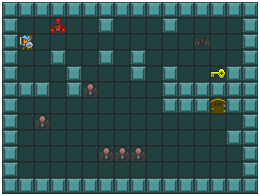

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=272356, Fri Oct  7 12:53:39 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -7.900000000000000e+01 1.0e+00 4.70e-01  5e-01  5e-01 0:00.1
    2     28 -8.400000000000000e+01 1.1e+00 4.65e-01  5e-01  5e-01 0:00.2
    3     42 -8.400000000000000e+01 1.1e+00 4.69e-01  5e-01  5e-01 0:00.3
   38    532 -1.080000000000000e+02 1.9e+00 9.70e-01  9e-01  1e+00 0:03.3
   86   1204 -1.090000000000000e+02 2.3e+00 8.43e-01  8e-01  9e-01 0:07.4
  100   1400 -1.090000000000000e+02 2.3e+00 6.64e-01  6e-01  7e-01 0:08.6
  101   1414 -1.090000000000000e+02 2.3e+00 6.58e-01  6e-01  7e-01 0:08.7
  102   1428 -1.090000000000000e+02 2.3e+00 6.38e-01  6e-01  7e-01 0:08.8
  103   1442 -1.090000000000000e+02 2.3e+00 6.12e-01  5e-01  7e-01 0:08.8
  104   1456 -1.090000000000000e+02 2.3e+00 5.98e-01  5e-01  7e-01 0:08.9
  105   1470 -1.090000000000000e+02 2.3e+00 5.83e-01  5e-01  6e-01 0:09.0
  106   1484 -1.090000

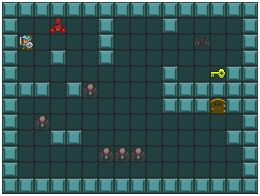

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=209272, Fri Oct  7 12:53:53 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -8.700000000000000e+01 1.0e+00 4.72e-01  5e-01  5e-01 0:00.1
    2     28 -9.400000000000000e+01 1.1e+00 4.57e-01  5e-01  5e-01 0:00.2
    3     42 -9.700000000000000e+01 1.1e+00 4.43e-01  4e-01  4e-01 0:00.3
   38    532 -1.040000000000000e+02 1.7e+00 3.38e-01  3e-01  4e-01 0:03.4
   84   1176 -1.040000000000000e+02 2.1e+00 2.23e-01  2e-01  3e-01 0:07.4
  100   1400 -1.040000000000000e+02 2.5e+00 2.83e-01  3e-01  3e-01 0:08.8
  110   1540 -1.040000000000000e+02 2.7e+00 2.61e-01  2e-01  3e-01 0:09.5
  122   1708 -1.050000000000000e+02 2.9e+00 3.09e-01  3e-01  4e-01 0:10.5
  126   1764 -1.050000000000000e+02 2.9e+00 2.94e-01  3e-01  4e-01 0:10.9
  136   1904 -1.050000000000000e+02 3.0e+00 2.53e-01  2e-01  3e-01 0:11.8
  137   1918 -1.050000000000000e+02 3.0e+00 2.52e-01  2e-01  3e-01 0:11.9
  138   1932 -1.050000

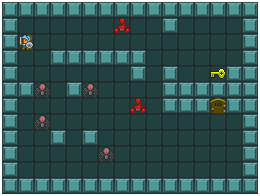

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=282983, Fri Oct  7 12:54:06 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -8.600000000000000e+01 1.0e+00 4.76e-01  5e-01  5e-01 0:00.1
    2     28 -8.600000000000000e+01 1.1e+00 4.71e-01  5e-01  5e-01 0:00.2
    3     42 -9.200000000000000e+01 1.1e+00 4.76e-01  5e-01  5e-01 0:00.3
   39    546 -1.080000000000000e+02 1.7e+00 4.97e-01  5e-01  5e-01 0:03.3
   52    728 -1.080000000000000e+02 1.8e+00 4.37e-01  4e-01  5e-01 0:04.5
   53    742 -1.080000000000000e+02 1.8e+00 4.27e-01  4e-01  5e-01 0:04.6
   56    784 -1.080000000000000e+02 1.8e+00 4.09e-01  4e-01  4e-01 0:04.8
   57    798 -1.080000000000000e+02 1.8e+00 4.13e-01  4e-01  4e-01 0:04.9
   58    812 -1.080000000000000e+02 1.8e+00 4.16e-01  4e-01  4e-01 0:05.0
   59    826 -1.080000000000000e+02 1.8e+00 4.33e-01  4e-01  5e-01 0:05.1
   60    840 -1.080000000000000e+02 1.8e+00 4.40e-01  4e-01  5e-01 0:05.2
   61    854 -1.080000

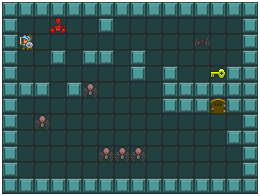

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=335189, Fri Oct  7 12:54:19 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -9.300000000000000e+01 1.0e+00 4.77e-01  5e-01  5e-01 0:00.1
    2     28 -9.300000000000000e+01 1.1e+00 4.66e-01  5e-01  5e-01 0:00.2
    3     42 -9.900000000000000e+01 1.1e+00 4.64e-01  5e-01  5e-01 0:00.3
   36    504 -1.040000000000000e+02 1.6e+00 4.30e-01  4e-01  5e-01 0:03.4
   37    518 -1.040000000000000e+02 1.6e+00 4.47e-01  4e-01  5e-01 0:03.4
   65    910 -1.040000000000000e+02 1.8e+00 4.38e-01  4e-01  5e-01 0:05.9
   66    924 -1.040000000000000e+02 1.8e+00 4.21e-01  4e-01  5e-01 0:06.0
   69    966 -1.040000000000000e+02 1.9e+00 3.83e-01  4e-01  4e-01 0:06.2
   70    980 -1.040000000000000e+02 1.9e+00 3.79e-01  3e-01  4e-01 0:06.3
   71    994 -1.040000000000000e+02 1.9e+00 3.79e-01  3e-01  4e-01 0:06.4
   74   1036 -1.040000000000000e+02 1.9e+00 3.76e-01  3e-01  4e-01 0:06.7
   82   1148 -1.040000

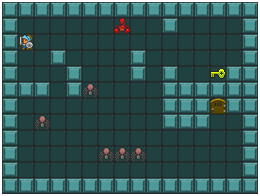

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=310676, Fri Oct  7 12:54:33 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -8.100000000000000e+01 1.0e+00 4.66e-01  5e-01  5e-01 0:00.1
    2     28 -8.600000000000000e+01 1.1e+00 4.52e-01  4e-01  5e-01 0:00.2
    3     42 -8.700000000000000e+01 1.1e+00 4.51e-01  4e-01  5e-01 0:00.3
   37    518 -9.300000000000000e+01 1.9e+00 8.47e-01  8e-01  1e+00 0:03.3
   51    714 -9.300000000000000e+01 2.2e+00 8.63e-01  8e-01  1e+00 0:04.6
   52    728 -9.300000000000000e+01 2.2e+00 8.52e-01  8e-01  1e+00 0:04.7
   93   1302 -9.800000000000000e+01 3.2e+00 1.45e+00  1e+00  2e+00 0:08.4
   96   1344 -9.800000000000000e+01 3.3e+00 1.45e+00  1e+00  2e+00 0:08.6
   99   1386 -9.800000000000000e+01 3.4e+00 1.29e+00  1e+00  2e+00 0:08.9
  100   1400 -9.800000000000000e+01 3.4e+00 1.26e+00  1e+00  2e+00 0:09.0
  101   1414 -9.800000000000000e+01 3.4e+00 1.23e+00  1e+00  2e+00 0:09.1
  102   1428 -9.800000

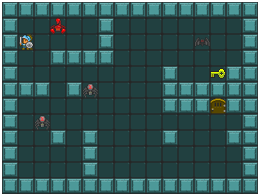

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=228918, Fri Oct  7 12:54:47 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -8.100000000000000e+01 1.0e+00 4.74e-01  5e-01  5e-01 0:00.1
    2     28 -8.200000000000000e+01 1.1e+00 4.57e-01  5e-01  5e-01 0:00.2
    3     42 -8.200000000000000e+01 1.1e+00 4.48e-01  4e-01  5e-01 0:00.3
   22    308 -8.800000000000000e+01 1.5e+00 4.34e-01  4e-01  5e-01 0:02.2
   68    952 -1.050000000000000e+02 2.3e+00 4.90e-01  5e-01  5e-01 0:06.2
  100   1400 -1.060000000000000e+02 2.8e+00 3.59e-01  3e-01  4e-01 0:08.9
  120   1680 -1.060000000000000e+02 3.1e+00 2.21e-01  2e-01  2e-01 0:10.8
  125   1750 -1.060000000000000e+02 3.1e+00 1.95e-01  2e-01  2e-01 0:11.2
  126   1764 -1.060000000000000e+02 3.1e+00 1.90e-01  2e-01  2e-01 0:11.3
  129   1806 -1.060000000000000e+02 3.1e+00 1.78e-01  2e-01  2e-01 0:11.5
  132   1848 -1.060000000000000e+02 3.1e+00 1.72e-01  2e-01  2e-01 0:11.8
  133   1862 -1.060000

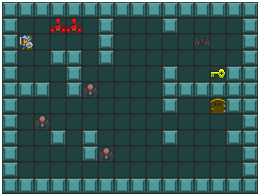

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=253550, Fri Oct  7 12:55:01 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -8.800000000000000e+01 1.0e+00 4.74e-01  5e-01  5e-01 0:00.1
    2     28 -9.000000000000000e+01 1.1e+00 4.67e-01  5e-01  5e-01 0:00.2
    3     42 -9.000000000000000e+01 1.1e+00 4.72e-01  5e-01  5e-01 0:00.3
   35    490 -1.060000000000000e+02 1.8e+00 5.96e-01  5e-01  6e-01 0:03.3
   57    798 -1.070000000000000e+02 2.0e+00 4.20e-01  4e-01  5e-01 0:05.3
   61    854 -1.070000000000000e+02 2.0e+00 4.22e-01  4e-01  5e-01 0:05.7
   62    868 -1.070000000000000e+02 2.1e+00 4.25e-01  4e-01  5e-01 0:05.8
   63    882 -1.070000000000000e+02 2.1e+00 4.36e-01  4e-01  5e-01 0:05.8
   64    896 -1.070000000000000e+02 2.1e+00 4.41e-01  4e-01  5e-01 0:05.9
   65    910 -1.070000000000000e+02 2.1e+00 4.42e-01  4e-01  5e-01 0:06.0
   72   1008 -1.070000000000000e+02 2.1e+00 4.39e-01  4e-01  5e-01 0:06.7
   73   1022 -1.070000

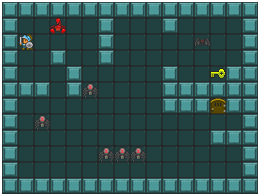

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=320853, Fri Oct  7 12:55:14 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -8.400000000000000e+01 1.0e+00 4.76e-01  5e-01  5e-01 0:00.1
    2     28 -8.400000000000000e+01 1.1e+00 4.64e-01  5e-01  5e-01 0:00.2
    3     42 -8.500000000000000e+01 1.1e+00 4.52e-01  4e-01  5e-01 0:00.3
   40    560 -8.600000000000000e+01 1.8e+00 6.67e-01  6e-01  7e-01 0:03.4
   82   1148 -8.700000000000000e+01 2.3e+00 6.42e-01  6e-01  7e-01 0:07.4
   88   1232 -8.700000000000000e+01 2.4e+00 6.24e-01  6e-01  7e-01 0:08.0
   89   1246 -8.700000000000000e+01 2.4e+00 6.31e-01  6e-01  7e-01 0:08.1
   90   1260 -8.700000000000000e+01 2.4e+00 6.45e-01  6e-01  7e-01 0:08.2
   93   1302 -8.700000000000000e+01 2.4e+00 6.47e-01  6e-01  7e-01 0:08.4
   94   1316 -8.700000000000000e+01 2.4e+00 6.47e-01  6e-01  7e-01 0:08.5
   95   1330 -8.700000000000000e+01 2.4e+00 6.42e-01  6e-01  7e-01 0:08.6
  100   1400 -8.800000

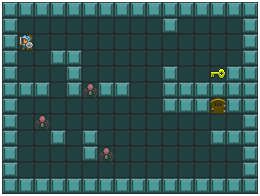

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=255385, Fri Oct  7 12:55:28 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -8.400000000000000e+01 1.0e+00 4.69e-01  5e-01  5e-01 0:00.1
    2     28 -8.700000000000000e+01 1.1e+00 4.62e-01  5e-01  5e-01 0:00.2
    3     42 -8.600000000000000e+01 1.1e+00 4.47e-01  4e-01  5e-01 0:00.3
   35    490 -1.080000000000000e+02 1.6e+00 5.62e-01  5e-01  6e-01 0:03.3
   67    938 -1.090000000000000e+02 2.0e+00 5.69e-01  5e-01  6e-01 0:06.2
   68    952 -1.090000000000000e+02 2.0e+00 5.70e-01  5e-01  6e-01 0:06.3
   69    966 -1.090000000000000e+02 2.0e+00 5.54e-01  5e-01  6e-01 0:06.4
   70    980 -1.090000000000000e+02 2.0e+00 5.47e-01  5e-01  6e-01 0:06.5
   71    994 -1.090000000000000e+02 2.0e+00 5.36e-01  5e-01  6e-01 0:06.6
   72   1008 -1.090000000000000e+02 2.0e+00 5.33e-01  5e-01  6e-01 0:06.7
   73   1022 -1.090000000000000e+02 2.0e+00 5.35e-01  5e-01  6e-01 0:06.7
   78   1092 -1.090000

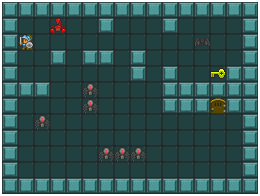

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=191971, Fri Oct  7 12:55:43 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -8.200000000000000e+01 1.0e+00 4.73e-01  5e-01  5e-01 0:00.1
    2     28 -8.400000000000000e+01 1.1e+00 4.61e-01  5e-01  5e-01 0:00.3
    3     42 -8.700000000000000e+01 1.1e+00 4.56e-01  4e-01  5e-01 0:00.4
   39    546 -9.500000000000000e+01 1.6e+00 3.93e-01  4e-01  4e-01 0:03.5
   53    742 -9.600000000000000e+01 1.8e+00 3.53e-01  3e-01  4e-01 0:04.6
   54    756 -9.600000000000000e+01 1.8e+00 3.47e-01  3e-01  4e-01 0:04.7
   69    966 -9.600000000000000e+01 1.9e+00 3.06e-01  3e-01  3e-01 0:05.9
   70    980 -9.600000000000000e+01 1.9e+00 2.98e-01  3e-01  3e-01 0:06.0
   71    994 -9.600000000000000e+01 1.9e+00 2.83e-01  3e-01  3e-01 0:06.1
   72   1008 -9.600000000000000e+01 1.9e+00 2.80e-01  3e-01  3e-01 0:06.2
   73   1022 -9.600000000000000e+01 1.9e+00 2.81e-01  3e-01  3e-01 0:06.2
   74   1036 -9.600000

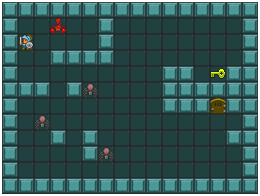

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=228167, Fri Oct  7 12:55:56 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -8.900000000000000e+01 1.0e+00 4.74e-01  5e-01  5e-01 0:00.1
    2     28 -9.600000000000000e+01 1.1e+00 4.65e-01  5e-01  5e-01 0:00.2
    3     42 -9.500000000000000e+01 1.1e+00 4.68e-01  5e-01  5e-01 0:00.3
   37    518 -1.020000000000000e+02 1.6e+00 3.38e-01  3e-01  4e-01 0:03.3
   83   1162 -1.040000000000000e+02 1.8e+00 2.34e-01  2e-01  2e-01 0:07.4
  100   1400 -1.040000000000000e+02 2.1e+00 1.90e-01  2e-01  2e-01 0:08.9
  106   1484 -1.040000000000000e+02 2.2e+00 1.79e-01  2e-01  2e-01 0:09.4
  107   1498 -1.040000000000000e+02 2.2e+00 1.74e-01  1e-01  2e-01 0:09.5
  108   1512 -1.040000000000000e+02 2.2e+00 1.69e-01  1e-01  2e-01 0:09.6
  109   1526 -1.040000000000000e+02 2.2e+00 1.67e-01  1e-01  2e-01 0:09.7
  114   1596 -1.040000000000000e+02 2.2e+00 1.61e-01  1e-01  2e-01 0:10.0
  115   1610 -1.040000

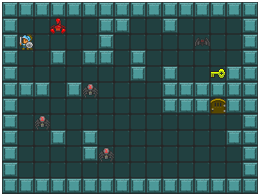

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=238148, Fri Oct  7 12:56:09 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -9.400000000000000e+01 1.0e+00 4.69e-01  5e-01  5e-01 0:00.1
    2     28 -1.000000000000000e+02 1.1e+00 4.58e-01  5e-01  5e-01 0:00.2
    3     42 -1.010000000000000e+02 1.1e+00 4.45e-01  4e-01  4e-01 0:00.3
   38    532 -1.080000000000000e+02 1.7e+00 6.25e-01  6e-01  7e-01 0:03.4
   48    672 -1.080000000000000e+02 1.9e+00 6.18e-01  6e-01  7e-01 0:04.2
   51    714 -1.080000000000000e+02 1.9e+00 5.93e-01  6e-01  6e-01 0:04.4
   59    826 -1.080000000000000e+02 2.0e+00 6.08e-01  6e-01  7e-01 0:05.0
   62    868 -1.080000000000000e+02 2.0e+00 6.13e-01  6e-01  7e-01 0:05.3
   63    882 -1.080000000000000e+02 2.0e+00 6.13e-01  6e-01  7e-01 0:05.3
   64    896 -1.080000000000000e+02 2.0e+00 6.07e-01  6e-01  7e-01 0:05.4
   65    910 -1.080000000000000e+02 2.0e+00 6.01e-01  6e-01  7e-01 0:05.5
   66    924 -1.080000

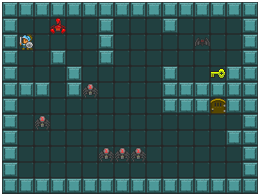

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=258667, Fri Oct  7 12:56:22 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -9.100000000000000e+01 1.0e+00 4.63e-01  5e-01  5e-01 0:00.1
    2     28 -9.200000000000000e+01 1.1e+00 4.47e-01  4e-01  5e-01 0:00.2
    3     42 -9.400000000000000e+01 1.1e+00 4.33e-01  4e-01  4e-01 0:00.3
   39    546 -1.080000000000000e+02 1.7e+00 5.18e-01  5e-01  5e-01 0:03.3
   59    826 -1.080000000000000e+02 2.1e+00 6.43e-01  6e-01  7e-01 0:05.0
   70    980 -1.080000000000000e+02 2.2e+00 6.22e-01  6e-01  7e-01 0:05.9
   93   1302 -1.080000000000000e+02 2.4e+00 5.92e-01  5e-01  7e-01 0:07.7
   94   1316 -1.080000000000000e+02 2.4e+00 6.00e-01  5e-01  7e-01 0:07.8
   95   1330 -1.080000000000000e+02 2.5e+00 6.06e-01  5e-01  7e-01 0:07.9
   96   1344 -1.080000000000000e+02 2.5e+00 6.11e-01  5e-01  7e-01 0:08.0
   97   1358 -1.080000000000000e+02 2.5e+00 6.11e-01  5e-01  7e-01 0:08.1
  100   1400 -1.080000

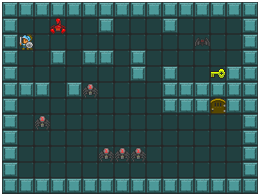

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=179190, Fri Oct  7 12:56:36 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -8.700000000000000e+01 1.0e+00 4.71e-01  5e-01  5e-01 0:00.1
    2     28 -9.200000000000000e+01 1.1e+00 4.44e-01  4e-01  4e-01 0:00.2
    3     42 -9.000000000000000e+01 1.1e+00 4.24e-01  4e-01  4e-01 0:00.3
   36    504 -9.700000000000000e+01 1.7e+00 4.49e-01  4e-01  5e-01 0:03.3
   43    602 -9.700000000000000e+01 1.8e+00 3.89e-01  4e-01  4e-01 0:04.0
   56    784 -9.700000000000000e+01 1.9e+00 3.59e-01  3e-01  4e-01 0:05.2
   57    798 -9.700000000000000e+01 1.9e+00 3.63e-01  3e-01  4e-01 0:05.3
   58    812 -9.700000000000000e+01 1.9e+00 3.63e-01  3e-01  4e-01 0:05.4
   59    826 -9.700000000000000e+01 1.9e+00 3.63e-01  3e-01  4e-01 0:05.5
   60    840 -9.700000000000000e+01 1.9e+00 3.73e-01  3e-01  4e-01 0:05.6
   61    854 -9.700000000000000e+01 1.9e+00 3.78e-01  4e-01  4e-01 0:05.7
   62    868 -9.700000

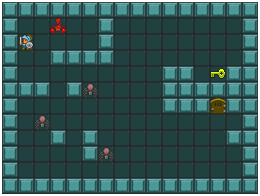

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=289380, Fri Oct  7 12:56:49 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -9.200000000000000e+01 1.0e+00 4.68e-01  5e-01  5e-01 0:00.1
    2     28 -9.200000000000000e+01 1.1e+00 4.50e-01  4e-01  5e-01 0:00.2
    3     42 -9.300000000000000e+01 1.1e+00 4.52e-01  4e-01  5e-01 0:00.3
   35    490 -9.500000000000000e+01 1.6e+00 5.07e-01  5e-01  5e-01 0:03.4
   59    826 -9.600000000000000e+01 1.9e+00 4.17e-01  4e-01  4e-01 0:05.4
   65    910 -9.600000000000000e+01 2.0e+00 3.69e-01  3e-01  4e-01 0:05.9
   66    924 -9.600000000000000e+01 2.0e+00 3.68e-01  3e-01  4e-01 0:06.0
   67    938 -9.600000000000000e+01 2.0e+00 3.62e-01  3e-01  4e-01 0:06.1
   68    952 -9.600000000000000e+01 2.0e+00 3.57e-01  3e-01  4e-01 0:06.2
   69    966 -9.600000000000000e+01 2.0e+00 3.57e-01  3e-01  4e-01 0:06.3
   70    980 -9.600000000000000e+01 2.0e+00 3.56e-01  3e-01  4e-01 0:06.4
   71    994 -9.600000

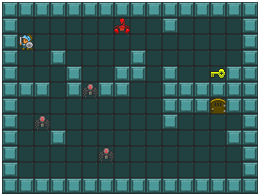

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=275078, Fri Oct  7 12:57:03 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -8.700000000000000e+01 1.0e+00 4.71e-01  5e-01  5e-01 0:00.1
    2     28 -9.100000000000000e+01 1.1e+00 4.53e-01  5e-01  5e-01 0:00.2
    3     42 -9.200000000000000e+01 1.1e+00 4.47e-01  4e-01  5e-01 0:00.3
   36    504 -1.080000000000000e+02 1.9e+00 7.05e-01  7e-01  8e-01 0:03.3
   85   1190 -1.090000000000000e+02 2.6e+00 6.85e-01  6e-01  9e-01 0:07.4
   95   1330 -1.090000000000000e+02 2.7e+00 5.91e-01  5e-01  8e-01 0:08.2
   96   1344 -1.090000000000000e+02 2.8e+00 5.86e-01  5e-01  8e-01 0:08.2
   97   1358 -1.090000000000000e+02 2.8e+00 5.90e-01  5e-01  8e-01 0:08.3
   98   1372 -1.090000000000000e+02 2.8e+00 5.86e-01  5e-01  8e-01 0:08.4
   99   1386 -1.090000000000000e+02 2.8e+00 5.87e-01  5e-01  8e-01 0:08.5
  100   1400 -1.090000000000000e+02 2.8e+00 5.86e-01  5e-01  8e-01 0:08.6
  101   1414 -1.090000

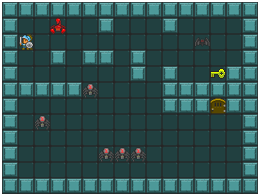

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=259833, Fri Oct  7 12:57:17 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -8.800000000000000e+01 1.0e+00 4.72e-01  5e-01  5e-01 0:00.1
    2     28 -9.300000000000000e+01 1.1e+00 4.66e-01  5e-01  5e-01 0:00.2
    3     42 -9.400000000000000e+01 1.1e+00 4.67e-01  5e-01  5e-01 0:00.3
   37    518 -1.080000000000000e+02 1.8e+00 4.91e-01  5e-01  5e-01 0:03.3
   40    560 -1.080000000000000e+02 1.9e+00 4.83e-01  5e-01  5e-01 0:03.6
   41    574 -1.080000000000000e+02 1.9e+00 4.86e-01  5e-01  5e-01 0:03.7
   42    588 -1.080000000000000e+02 1.9e+00 4.91e-01  5e-01  5e-01 0:03.8
   55    770 -1.080000000000000e+02 2.0e+00 4.76e-01  4e-01  5e-01 0:04.9
   58    812 -1.080000000000000e+02 1.9e+00 4.60e-01  4e-01  5e-01 0:05.2
   61    854 -1.080000000000000e+02 2.0e+00 4.25e-01  4e-01  5e-01 0:05.4
   62    868 -1.080000000000000e+02 2.0e+00 4.19e-01  4e-01  5e-01 0:05.5
   63    882 -1.080000

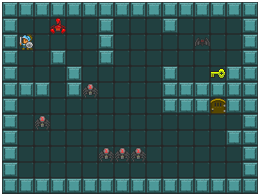

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=268439, Fri Oct  7 12:57:30 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -9.100000000000000e+01 1.0e+00 4.78e-01  5e-01  5e-01 0:00.1
    2     28 -9.200000000000000e+01 1.1e+00 4.66e-01  5e-01  5e-01 0:00.2
    3     42 -9.200000000000000e+01 1.1e+00 4.56e-01  5e-01  5e-01 0:00.3
   41    574 -1.010000000000000e+02 1.8e+00 4.94e-01  5e-01  5e-01 0:03.3
   61    854 -1.010000000000000e+02 2.0e+00 4.13e-01  4e-01  5e-01 0:05.0
   62    868 -1.010000000000000e+02 2.0e+00 4.00e-01  4e-01  4e-01 0:05.1
   65    910 -1.010000000000000e+02 2.0e+00 3.79e-01  4e-01  4e-01 0:05.4
  100   1400 -1.020000000000000e+02 2.2e+00 3.47e-01  3e-01  4e-01 0:08.4
  111   1554 -1.020000000000000e+02 2.4e+00 3.07e-01  3e-01  3e-01 0:09.4
  112   1568 -1.020000000000000e+02 2.4e+00 3.10e-01  3e-01  3e-01 0:09.5
  113   1582 -1.020000000000000e+02 2.4e+00 3.07e-01  3e-01  3e-01 0:09.5
  114   1596 -1.020000

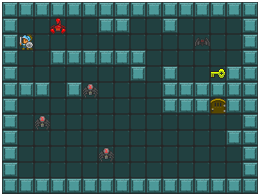

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=225219, Fri Oct  7 12:57:43 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -9.100000000000000e+01 1.0e+00 4.68e-01  5e-01  5e-01 0:00.1
    2     28 -9.500000000000000e+01 1.1e+00 4.51e-01  4e-01  5e-01 0:00.2
    3     42 -9.300000000000000e+01 1.1e+00 4.43e-01  4e-01  4e-01 0:00.3
   38    532 -1.030000000000000e+02 1.8e+00 4.27e-01  4e-01  5e-01 0:03.3
   87   1218 -1.040000000000000e+02 2.2e+00 3.19e-01  3e-01  4e-01 0:07.4
  100   1400 -1.040000000000000e+02 2.3e+00 3.09e-01  3e-01  4e-01 0:08.5
  103   1442 -1.040000000000000e+02 2.3e+00 3.00e-01  3e-01  3e-01 0:08.7
  104   1456 -1.040000000000000e+02 2.3e+00 3.00e-01  3e-01  3e-01 0:08.8
  110   1540 -1.040000000000000e+02 2.4e+00 3.26e-01  3e-01  4e-01 0:09.4
  115   1610 -1.040000000000000e+02 2.4e+00 3.38e-01  3e-01  4e-01 0:09.8
  122   1708 -1.040000000000000e+02 2.5e+00 3.32e-01  3e-01  4e-01 0:10.4
  123   1722 -1.040000

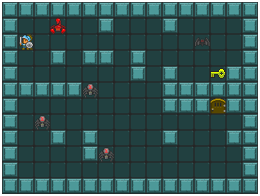

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=243862, Fri Oct  7 12:57:56 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -9.800000000000000e+01 1.0e+00 4.83e-01  5e-01  5e-01 0:00.1
    2     28 -9.800000000000000e+01 1.1e+00 4.74e-01  5e-01  5e-01 0:00.2
    3     42 -1.010000000000000e+02 1.1e+00 4.75e-01  5e-01  5e-01 0:00.3
   28    392 -1.030000000000000e+02 1.8e+00 7.91e-01  8e-01  9e-01 0:02.6
   29    406 -1.030000000000000e+02 1.8e+00 8.11e-01  8e-01  9e-01 0:02.7
   30    420 -1.030000000000000e+02 1.8e+00 8.34e-01  8e-01  9e-01 0:02.8
   67    938 -1.050000000000000e+02 2.1e+00 7.82e-01  7e-01  9e-01 0:06.0
   68    952 -1.050000000000000e+02 2.2e+00 7.86e-01  7e-01  9e-01 0:06.1
   77   1078 -1.050000000000000e+02 2.3e+00 8.16e-01  8e-01  9e-01 0:06.8
   78   1092 -1.050000000000000e+02 2.3e+00 7.99e-01  7e-01  9e-01 0:06.9
   86   1204 -1.050000000000000e+02 2.3e+00 7.50e-01  7e-01  8e-01 0:07.6
   87   1218 -1.050000

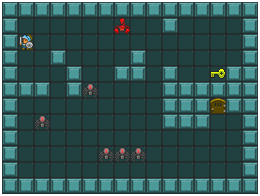

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=269396, Fri Oct  7 12:58:10 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -8.600000000000000e+01 1.0e+00 4.60e-01  5e-01  5e-01 0:00.1
    2     28 -8.800000000000000e+01 1.1e+00 4.38e-01  4e-01  4e-01 0:00.2
    3     42 -8.900000000000000e+01 1.1e+00 4.21e-01  4e-01  4e-01 0:00.3
   39    546 -1.010000000000000e+02 1.9e+00 7.09e-01  7e-01  8e-01 0:03.3
   88   1232 -1.030000000000000e+02 2.3e+00 6.81e-01  6e-01  8e-01 0:07.3
   89   1246 -1.030000000000000e+02 2.3e+00 6.83e-01  6e-01  8e-01 0:07.4
   90   1260 -1.030000000000000e+02 2.3e+00 6.92e-01  6e-01  8e-01 0:07.4
   95   1330 -1.030000000000000e+02 2.4e+00 6.95e-01  6e-01  8e-01 0:07.8
   96   1344 -1.030000000000000e+02 2.5e+00 6.96e-01  6e-01  8e-01 0:07.9
   97   1358 -1.030000000000000e+02 2.5e+00 7.00e-01  6e-01  8e-01 0:08.0
   98   1372 -1.030000000000000e+02 2.5e+00 7.03e-01  6e-01  9e-01 0:08.1
  100   1400 -1.030000

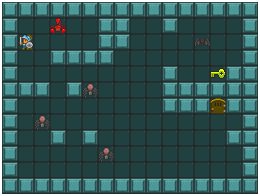

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=277179, Fri Oct  7 12:58:22 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -7.800000000000000e+01 1.0e+00 4.64e-01  5e-01  5e-01 0:00.1
    2     28 -7.800000000000000e+01 1.1e+00 4.53e-01  4e-01  5e-01 0:00.2
    3     42 -7.900000000000000e+01 1.1e+00 4.50e-01  4e-01  5e-01 0:00.3
   36    504 -9.500000000000000e+01 1.9e+00 8.11e-01  8e-01  9e-01 0:03.3
   82   1148 -1.040000000000000e+02 2.3e+00 6.46e-01  6e-01  7e-01 0:07.3
  100   1400 -1.040000000000000e+02 2.5e+00 5.87e-01  5e-01  6e-01 0:08.8
  107   1498 -1.040000000000000e+02 2.5e+00 5.26e-01  5e-01  6e-01 0:09.4
  110   1540 -1.040000000000000e+02 2.6e+00 5.21e-01  5e-01  6e-01 0:09.6
  111   1554 -1.040000000000000e+02 2.6e+00 5.20e-01  5e-01  6e-01 0:09.7
  120   1680 -1.040000000000000e+02 2.7e+00 4.44e-01  4e-01  5e-01 0:10.4
  121   1694 -1.040000000000000e+02 2.7e+00 4.33e-01  4e-01  5e-01 0:10.5
  122   1708 -1.040000

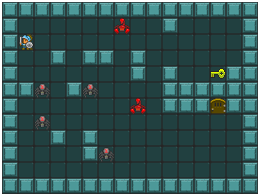

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=181499, Fri Oct  7 12:58:36 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -8.600000000000000e+01 1.0e+00 4.71e-01  5e-01  5e-01 0:00.1
    2     28 -8.700000000000000e+01 1.1e+00 4.51e-01  4e-01  5e-01 0:00.2
    3     42 -8.800000000000000e+01 1.1e+00 4.46e-01  4e-01  4e-01 0:00.3
   40    560 -9.600000000000000e+01 1.9e+00 9.01e-01  8e-01  1e+00 0:03.4
   86   1204 -1.000000000000000e+02 2.1e+00 4.61e-01  4e-01  6e-01 0:07.4
   95   1330 -1.000000000000000e+02 2.2e+00 3.75e-01  3e-01  5e-01 0:08.1
  100   1400 -1.000000000000000e+02 2.2e+00 3.69e-01  3e-01  5e-01 0:08.5
  101   1414 -1.000000000000000e+02 2.2e+00 3.74e-01  3e-01  5e-01 0:08.6
  102   1428 -1.000000000000000e+02 2.2e+00 3.74e-01  3e-01  5e-01 0:08.7
  103   1442 -1.000000000000000e+02 2.2e+00 3.85e-01  4e-01  5e-01 0:08.7
  104   1456 -1.000000000000000e+02 2.2e+00 3.98e-01  4e-01  5e-01 0:08.8
  105   1470 -1.000000

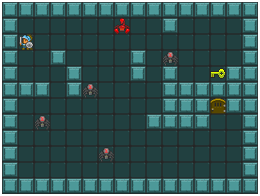

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=228419, Fri Oct  7 12:58:49 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -8.700000000000000e+01 1.0e+00 4.70e-01  5e-01  5e-01 0:00.1
    2     28 -8.700000000000000e+01 1.1e+00 4.59e-01  5e-01  5e-01 0:00.2
    3     42 -9.200000000000000e+01 1.1e+00 4.57e-01  5e-01  5e-01 0:00.3
   39    546 -1.030000000000000e+02 1.6e+00 4.36e-01  4e-01  5e-01 0:03.3
   41    574 -1.030000000000000e+02 1.6e+00 4.28e-01  4e-01  5e-01 0:03.5
   42    588 -1.030000000000000e+02 1.6e+00 4.20e-01  4e-01  5e-01 0:03.6
   43    602 -1.030000000000000e+02 1.6e+00 4.16e-01  4e-01  4e-01 0:03.7
   44    616 -1.030000000000000e+02 1.7e+00 4.16e-01  4e-01  4e-01 0:03.8
   45    630 -1.030000000000000e+02 1.7e+00 4.12e-01  4e-01  4e-01 0:03.9
   46    644 -1.030000000000000e+02 1.7e+00 4.12e-01  4e-01  4e-01 0:03.9
   50    700 -1.030000000000000e+02 1.7e+00 3.83e-01  4e-01  4e-01 0:04.3
   51    714 -1.030000

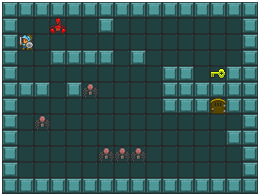

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=228139, Fri Oct  7 12:59:02 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -8.400000000000000e+01 1.0e+00 4.73e-01  5e-01  5e-01 0:00.1
    2     28 -8.900000000000000e+01 1.1e+00 4.61e-01  5e-01  5e-01 0:00.3
    3     42 -9.100000000000000e+01 1.1e+00 4.57e-01  5e-01  5e-01 0:00.4
   29    406 -9.400000000000000e+01 1.5e+00 4.57e-01  4e-01  5e-01 0:02.6
   30    420 -9.400000000000000e+01 1.5e+00 4.56e-01  4e-01  5e-01 0:02.6
   31    434 -9.400000000000000e+01 1.5e+00 4.48e-01  4e-01  5e-01 0:02.7
   32    448 -9.400000000000000e+01 1.5e+00 4.51e-01  4e-01  5e-01 0:02.8
   42    588 -9.400000000000000e+01 1.6e+00 4.03e-01  4e-01  4e-01 0:03.7
   47    658 -9.400000000000000e+01 1.6e+00 4.01e-01  4e-01  4e-01 0:04.1
   48    672 -9.400000000000000e+01 1.6e+00 4.07e-01  4e-01  4e-01 0:04.2
   49    686 -9.400000000000000e+01 1.7e+00 4.18e-01  4e-01  5e-01 0:04.3
   50    700 -9.400000

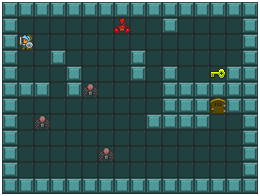

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=233827, Fri Oct  7 12:59:15 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -8.200000000000000e+01 1.0e+00 4.69e-01  5e-01  5e-01 0:00.1
    2     28 -8.300000000000000e+01 1.1e+00 4.42e-01  4e-01  4e-01 0:00.2
    3     42 -8.700000000000000e+01 1.1e+00 4.24e-01  4e-01  4e-01 0:00.3
   36    504 -9.300000000000000e+01 1.5e+00 3.74e-01  4e-01  4e-01 0:03.3
   84   1176 -1.020000000000000e+02 2.3e+00 3.40e-01  3e-01  4e-01 0:07.3
  100   1400 -1.020000000000000e+02 2.6e+00 2.87e-01  3e-01  3e-01 0:08.6
  114   1596 -1.020000000000000e+02 3.0e+00 3.33e-01  3e-01  4e-01 0:09.7
  119   1666 -1.020000000000000e+02 3.1e+00 3.40e-01  3e-01  4e-01 0:10.1
  120   1680 -1.020000000000000e+02 3.2e+00 3.43e-01  3e-01  4e-01 0:10.2
  121   1694 -1.020000000000000e+02 3.2e+00 3.44e-01  3e-01  4e-01 0:10.3
  122   1708 -1.020000000000000e+02 3.2e+00 3.44e-01  3e-01  4e-01 0:10.4
  123   1722 -1.020000

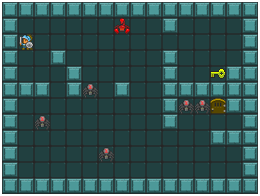

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=287836, Fri Oct  7 12:59:28 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -8.300000000000000e+01 1.0e+00 4.71e-01  5e-01  5e-01 0:00.1
    2     28 -8.600000000000000e+01 1.1e+00 4.62e-01  5e-01  5e-01 0:00.2
    3     42 -8.400000000000000e+01 1.1e+00 4.56e-01  4e-01  5e-01 0:00.3
   39    546 -1.040000000000000e+02 2.1e+00 1.03e+00  1e+00  1e+00 0:03.4
   61    854 -1.040000000000000e+02 2.3e+00 7.85e-01  7e-01  9e-01 0:05.3
   64    896 -1.040000000000000e+02 2.3e+00 7.28e-01  7e-01  8e-01 0:05.6
   65    910 -1.040000000000000e+02 2.3e+00 7.16e-01  7e-01  8e-01 0:05.6
   66    924 -1.040000000000000e+02 2.3e+00 6.99e-01  7e-01  8e-01 0:05.8
   67    938 -1.040000000000000e+02 2.3e+00 6.79e-01  6e-01  8e-01 0:05.8
   68    952 -1.040000000000000e+02 2.3e+00 6.63e-01  6e-01  8e-01 0:05.9
   69    966 -1.040000000000000e+02 2.3e+00 6.48e-01  6e-01  7e-01 0:06.0
   70    980 -1.040000

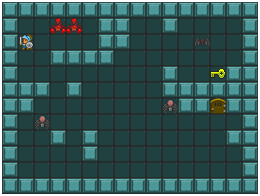

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=267693, Fri Oct  7 12:59:41 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -8.400000000000000e+01 1.0e+00 4.77e-01  5e-01  5e-01 0:00.1
    2     28 -8.600000000000000e+01 1.1e+00 4.60e-01  5e-01  5e-01 0:00.2
    3     42 -9.600000000000000e+01 1.1e+00 4.53e-01  4e-01  5e-01 0:00.3
   39    546 -1.010000000000000e+02 1.9e+00 7.08e-01  7e-01  8e-01 0:03.3
   82   1148 -1.020000000000000e+02 2.4e+00 6.05e-01  5e-01  6e-01 0:07.2
   87   1218 -1.020000000000000e+02 2.4e+00 5.84e-01  5e-01  6e-01 0:07.6
   88   1232 -1.020000000000000e+02 2.4e+00 5.87e-01  5e-01  6e-01 0:07.6
   91   1274 -1.020000000000000e+02 2.4e+00 5.96e-01  5e-01  7e-01 0:07.9
   98   1372 -1.020000000000000e+02 2.5e+00 5.33e-01  5e-01  6e-01 0:08.5
  100   1400 -1.020000000000000e+02 2.5e+00 5.43e-01  5e-01  6e-01 0:08.7
  103   1442 -1.020000000000000e+02 2.5e+00 5.15e-01  5e-01  6e-01 0:08.9
  108   1512 -1.020000

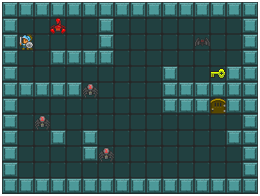

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=248316, Fri Oct  7 12:59:54 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -9.600000000000000e+01 1.0e+00 4.66e-01  5e-01  5e-01 0:00.1
    2     28 -8.600000000000000e+01 1.1e+00 4.48e-01  4e-01  5e-01 0:00.2
    3     42 -9.000000000000000e+01 1.1e+00 4.36e-01  4e-01  4e-01 0:00.3
   38    532 -1.090000000000000e+02 1.7e+00 7.79e-01  7e-01  9e-01 0:03.3
   71    994 -1.090000000000000e+02 2.2e+00 8.43e-01  8e-01  9e-01 0:05.9
   76   1064 -1.090000000000000e+02 2.2e+00 8.90e-01  8e-01  1e+00 0:06.3
   83   1162 -1.090000000000000e+02 2.3e+00 8.77e-01  8e-01  1e+00 0:06.9
   84   1176 -1.090000000000000e+02 2.3e+00 8.70e-01  8e-01  1e+00 0:07.0
   85   1190 -1.090000000000000e+02 2.3e+00 8.54e-01  8e-01  9e-01 0:07.0
   92   1288 -1.090000000000000e+02 2.3e+00 8.40e-01  8e-01  9e-01 0:07.6
   93   1302 -1.090000000000000e+02 2.4e+00 8.46e-01  8e-01  9e-01 0:07.7
   94   1316 -1.090000

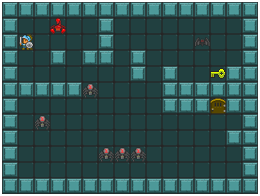

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=233306, Fri Oct  7 13:00:07 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -9.000000000000000e+01 1.0e+00 4.70e-01  5e-01  5e-01 0:00.1
    2     28 -9.100000000000000e+01 1.1e+00 4.48e-01  4e-01  5e-01 0:00.3
    3     42 -9.600000000000000e+01 1.1e+00 4.40e-01  4e-01  4e-01 0:00.4
   36    504 -1.090000000000000e+02 2.0e+00 1.18e+00  1e+00  1e+00 0:03.4
   81   1134 -1.090000000000000e+02 2.7e+00 1.39e+00  1e+00  2e+00 0:07.0
   85   1190 -1.090000000000000e+02 2.8e+00 1.29e+00  1e+00  2e+00 0:07.3
   86   1204 -1.090000000000000e+02 2.8e+00 1.26e+00  1e+00  2e+00 0:07.4
   87   1218 -1.090000000000000e+02 2.8e+00 1.25e+00  1e+00  2e+00 0:07.4
   88   1232 -1.090000000000000e+02 2.8e+00 1.22e+00  1e+00  2e+00 0:07.5
   98   1372 -1.090000000000000e+02 2.8e+00 1.03e+00  9e-01  1e+00 0:08.3
   99   1386 -1.090000000000000e+02 2.9e+00 1.03e+00  1e+00  1e+00 0:08.4
  100   1400 -1.090000

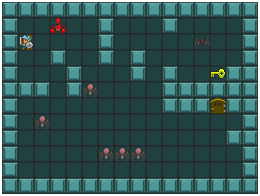

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=202444, Fri Oct  7 13:00:20 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -8.700000000000000e+01 1.0e+00 4.72e-01  5e-01  5e-01 0:00.1
    2     28 -8.400000000000000e+01 1.1e+00 4.65e-01  5e-01  5e-01 0:00.2
    3     42 -9.000000000000000e+01 1.1e+00 4.65e-01  5e-01  5e-01 0:00.3
   38    532 -1.000000000000000e+02 1.7e+00 6.53e-01  6e-01  7e-01 0:03.3
   83   1162 -1.020000000000000e+02 2.0e+00 4.39e-01  4e-01  5e-01 0:07.4
   90   1260 -1.020000000000000e+02 2.0e+00 4.33e-01  4e-01  5e-01 0:08.1
  100   1400 -1.020000000000000e+02 2.1e+00 4.26e-01  4e-01  5e-01 0:09.0
  112   1568 -1.020000000000000e+02 2.2e+00 3.63e-01  3e-01  4e-01 0:09.9
  113   1582 -1.020000000000000e+02 2.2e+00 3.63e-01  3e-01  4e-01 0:10.0
  146   2044 -1.030000000000000e+02 2.5e+00 2.94e-01  3e-01  3e-01 0:12.7
  147   2058 -1.030000000000000e+02 2.5e+00 2.92e-01  3e-01  3e-01 0:12.8
  148   2072 -1.030000

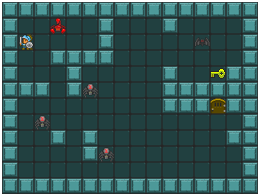

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=229257, Fri Oct  7 13:00:33 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -8.600000000000000e+01 1.0e+00 4.71e-01  5e-01  5e-01 0:00.1
    2     28 -8.900000000000000e+01 1.1e+00 4.56e-01  5e-01  5e-01 0:00.3
    3     42 -8.800000000000000e+01 1.1e+00 4.45e-01  4e-01  5e-01 0:00.4
   36    504 -9.700000000000000e+01 1.7e+00 5.06e-01  5e-01  5e-01 0:03.5
   75   1050 -9.600000000000000e+01 1.9e+00 5.36e-01  5e-01  6e-01 0:06.9
   76   1064 -9.600000000000000e+01 1.9e+00 5.10e-01  5e-01  6e-01 0:07.0
  100   1400 -9.600000000000000e+01 2.2e+00 5.15e-01  4e-01  6e-01 0:08.9
  150   2100 -9.700000000000000e+01 3.3e+00 6.67e-01  6e-01  8e-01 0:12.9


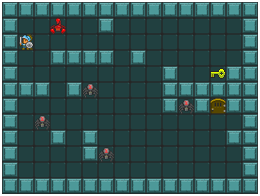

mean score:-102.7
mean playability:1.0


In [31]:
scores = []
playables = []

for i in range(50):
    x = torch.randn(config.latent_size).to(device)
    es = cma.CMAEvolutionStrategy(x.tolist(),0.5)
    es.optimize(fitnessf1,iterations=150,min_iterations=150)
    
    # es.optimize(fitness)
    best = np.array(es.best.get()[0])
    level = generator(torch.FloatTensor(best))
    level_str = tensor_to_level_str('zelda', level)
    playable = check_playable(level_str[0], config.env_fullname)
    playables.append(1 if playable else 0)
    if playable:
        scores.append(fitnessf1(best))
    show(torch.FloatTensor(best))

print(f"mean score:{np.array(scores).mean()}")
print(f"mean playability:{np.array(playables).mean()}")

    

In [46]:
print("mean:", sum/N)


mean: 58.3
